# Импорт данных

Будем сравнивать различные модели для базового прогноза. 

### Для этого импортируем несколько различных показателя:
- Индекс промышленного производства
- Индекс потребительских цен
- Внешнеторговый оборот
- Инвестиции в основной капитал
- Оборот розничной торговли
- Обьем вкладов


### Также сравним качество предсказаний для:
- квартальных и ежемесячных даннных
- с сезонностью (в % к предыдущему месяцу) и без сезонности (В % к соответствующему периоду предыдущего года)

In [1]:
import numpy as np
import pandas as pd
from datetime import date

import warnings
warnings.filterwarnings('ignore')

In [15]:
date_start = date(year=2015, month=1, day=1)

def data_prerpocess(df):
    """Приводим дату к нужнмоу формату, удаляем лишние столбцы, сортируем по дате, оставим только от 2015 года"""
    
    df.date = pd.to_datetime(df.date, format='%d.%m.%Y').dt.date

    # Очищаем данные с критической точки (обычно начало 2015 года) и сортируем по дате
    # Важно чтобы первые значения были ~2015 а последние уже наши дни
    # Тажке убираем лишние столбцы
    df = df[df.date > date_start].sort_values(by='date').drop('dataset', axis=1)
    
    return df

### Макроиндексы

In [13]:
path = './данные для исследований/'

In [28]:
indexes = {
    'Новостной индекс ЦБ': pd.read_csv(path + 'Новостной идекс ЦБ, Россия — Диаграмма.csv', sep=';'),
    'Спрос на промышленность': pd.read_csv(path + 'Оценка изменения спроса на продукцию, товары, услуги (промышленность), пункты, Россия — Диаграмма.csv', sep=';'),
    'ИПЦ': pd.read_csv(path + 'Индекс потребительских цен, Россия — Диаграмма.csv', sep=';'),
    'ИПП': pd.read_csv(path + 'Индекс промышленного производства, Россия — Диаграмма.csv', sep=';'),
    'Оборот розничной торговли': pd.read_csv(path + 'Оборот розничной торговли, Россия — Диаграмма.csv', sep=';'),
    'Погрузка на сети РЖД': pd.read_csv(path + 'Погрузка на сети РЖД, млн тонн, Россия — Диаграмма.csv', sep=';')
}

indexes = {index: data_prerpocess(df) for index, df in indexes.items()}

# Можешь эти данные на гит выложить, чтоб я мог запустить код?

# Визуализация

In [9]:
import matplotlib.pyplot as plt

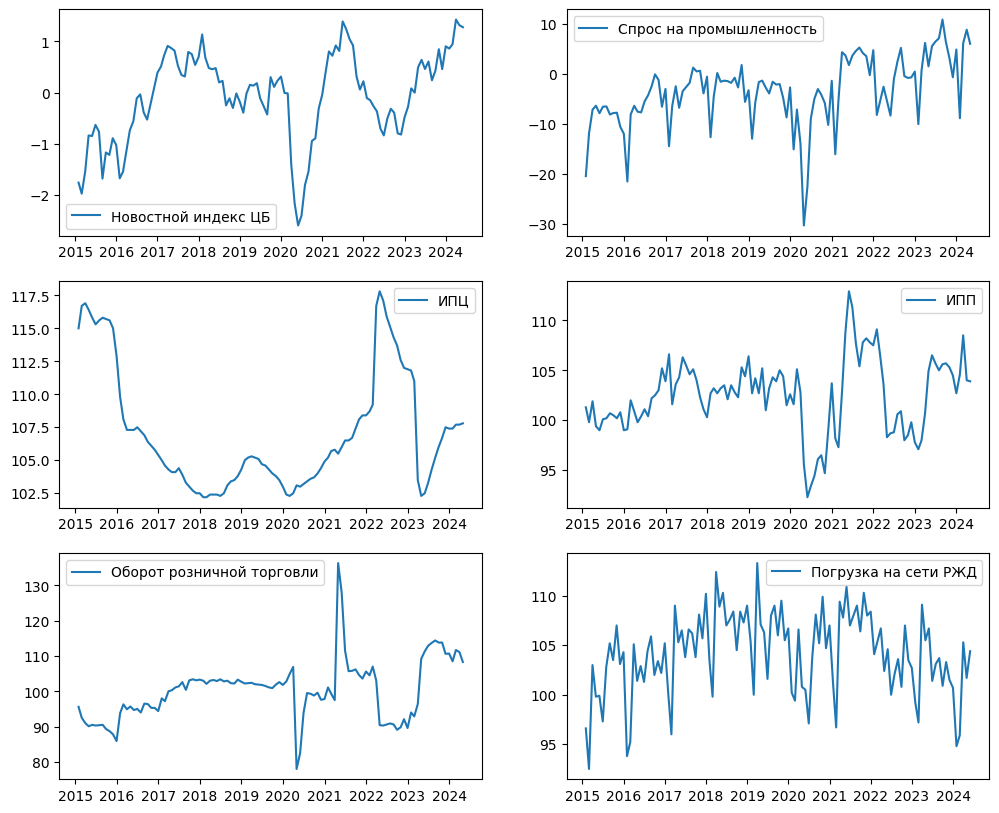

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

k = 0
for i in range(3):
    for j in range(2):
        label, data = list(indexes.items())[k]
        k += 1
                
        axes[i][j].plot(data.date, data.iloc[:, 1], label=label)
        axes[i][j].legend()


# Предобработка

Приведем среднее значения к 0 и стандартное отклонение к 1, чтобы улучшить качество нейросети

In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
scalers = dict()

for index, df in indexes.items():    
    goal = df.columns[-1]
    
    scalers[index] = StandardScaler().fit(df[[goal]])
    df['z_goal'] = scalers[index].transform(df[[goal]])

In [32]:
indexes['ИПЦ'].head(3)

,date,"Индекс потребительских цен, Россия: в % к предыдущему месяцу",z_goal
192,2015-01-31,115.0,1.756243
193,2015-02-28,116.7,2.132891
194,2015-03-31,116.9,2.177203


и обратно переводим

In [33]:
scalers['ИПЦ'].inverse_transform(indexes['ИПЦ'][['z_goal']])[:3]

array([[115. ],
       [116.7],
       [116.9]])

# Создание модели

- Сравним GRU и LSTM
- А также сравним итерационные модели, и модели которые сразу возвращают вектор значений

In [35]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.layers import GRU, Dropout, Dense

## Гиперпараметры модели

In [68]:
from dataclasses import dataclass, field

@dataclass
class ModelConfig:
    lookback         = 12   # Сколько берем данных для прогноза
    forecast_horizon = 3    # На сколько делаем прогноз
    n_layers         = 2    # Количество слоев
    units            = 2    # Количество нейронов на каждом слое
    batch_size       = 5
    epochs           = 100
    learning_rate    = 0.000001 
    
    input_shape: tuple = (lookback, 1)
        
# предлагаю это все и выносить в гиперпараметры для пользователя + шаг градиентного спуска и выбор модели GRU или LSTM

## Создание модели

In [69]:
def get_model():
    model = Sequential()
    # модель делает прогноз на 1 месяц, далее итерационно
    horizon = 1

    for _ in range(ModelConfig.n_layers - 1):        
        model.add(GRU(units=ModelConfig.units, input_shape=(ModelConfig.lookback, 1), return_sequences=True))
        
    model.add(GRU(units=ModelConfig.units, input_shape=(ModelConfig.lookback, 1), return_sequences=False))
    model.add(Dense(units=horizon))
    
    model.compile(optimizer=Adam(learning_rate=ModelConfig.learning_rate), loss='mse', metrics=['MAE', 'MAPE'])  #шаг LR тоже луше гиперпараметром делать. Стоит попробовать 0.001 для скалированных данных по умолчанию использовать.    
    
    return model

In [70]:
model = get_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 12, 2)             30        
                                                                 
 gru_10 (GRU)                (None, 2)                 36        
                                                                 
 dense_8 (Dense)             (None, 1)                 3         
                                                                 
Total params: 69 (276.00 Byte)
Trainable params: 69 (276.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
from tensorflow import compat
compat.v2.random.set_seed(1)

# Обучение моделей

In [46]:
import numpy as np
from typing import Iterable
from sklearn.model_selection import train_test_split

In [48]:
def reshape_data_for_model(data: Iterable, lookback: int = 12, horizon: int = 1) -> tuple[np.array, np.array]:
    """
    Создает батчи по lookback месяцев для иксов и по horizon месяца для игреков
    
    Также приводит к формату данных для RNN
    """
    
    data_range = range(lookback, len(data) - horizon)
    
    x = np.array([data[i - lookback:i] for i in data_range])
    x = np.reshape(x, (x.shape[0], lookback, 1))

    y = np.array([data[i:i + horizon] for i in data_range])
    
    return x, y

# Сравнение моделей

In [49]:
models = dict()

In [59]:
def get_fitted_model(z_goal):
    X, y = reshape_data_for_model(z_goal.values, ModelConfig.lookback, ModelConfig.forecast_horizon)
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    model = get_model()
    model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=ModelConfig.batch_size, epochs=ModelConfig.epochs)

    return model

In [60]:
def fit_all_models():
    # Название индекса: обученная модель
    return {index: get_fitted_model(z_goal=df.z_goal) for index, df in indexes.items()}

# GRU итерационная

In [71]:
models = fit_all_models()

Epoch 1/100
16/16 [==============================] - 5s 76ms/step - loss: 0.9481 - MAE: 0.7667 - MAPE: 120.5444 - val_loss: 1.0872 - val_MAE: 0.8122 - val_MAPE: 115.0475
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.9481 - MAE: 0.7667 - MAPE: 120.5341 - val_loss: 1.0871 - val_MAE: 0.8122 - val_MAPE: 115.0380
Epoch 3/100
16/16 [==============================] - 0s 17ms/step - loss: 0.9481 - MAE: 0.7667 - MAPE: 120.5261 - val_loss: 1.0871 - val_MAE: 0.8121 - val_MAPE: 115.0278
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 0.9480 - MAE: 0.7666 - MAPE: 120.5171 - val_loss: 1.0871 - val_MAE: 0.8121 - val_MAPE: 115.0186
Epoch 5/100
16/16 [==============================] - 0s 19ms/step - loss: 0.9480 - MAE: 0.7666 - MAPE: 120.5098 - val_loss: 1.0870 - val_MAE: 0.8121 - val_MAPE: 115.0105
Epoch 6/100
16/16 [==============================] - 0s 15ms/step - loss: 0.9480 - MAE: 0.7666 - MAPE: 120.5013 - val_loss: 1.0870 - val_MAE: 0.8121 -

In [62]:
models

{'Новостной индекс ЦБ': <keras.src.engine.sequential.Sequential at 0x7f9058232f90>,
 'Спрос на промышленность': <keras.src.engine.sequential.Sequential at 0x7f90454ce990>,
 'ИПЦ': <keras.src.engine.sequential.Sequential at 0x7f9045ffbf10>,
 'ИПП': <keras.src.engine.sequential.Sequential at 0x7f9045db21d0>,
 'Оборот розничной торговли': <keras.src.engine.sequential.Sequential at 0x7f902b74e990>,
 'Погрузка на сети РЖД': <keras.src.engine.sequential.Sequential at 0x7f90448c3510>}

## Визуализация моделей

4/4 [==============================] - 0s 4ms/step


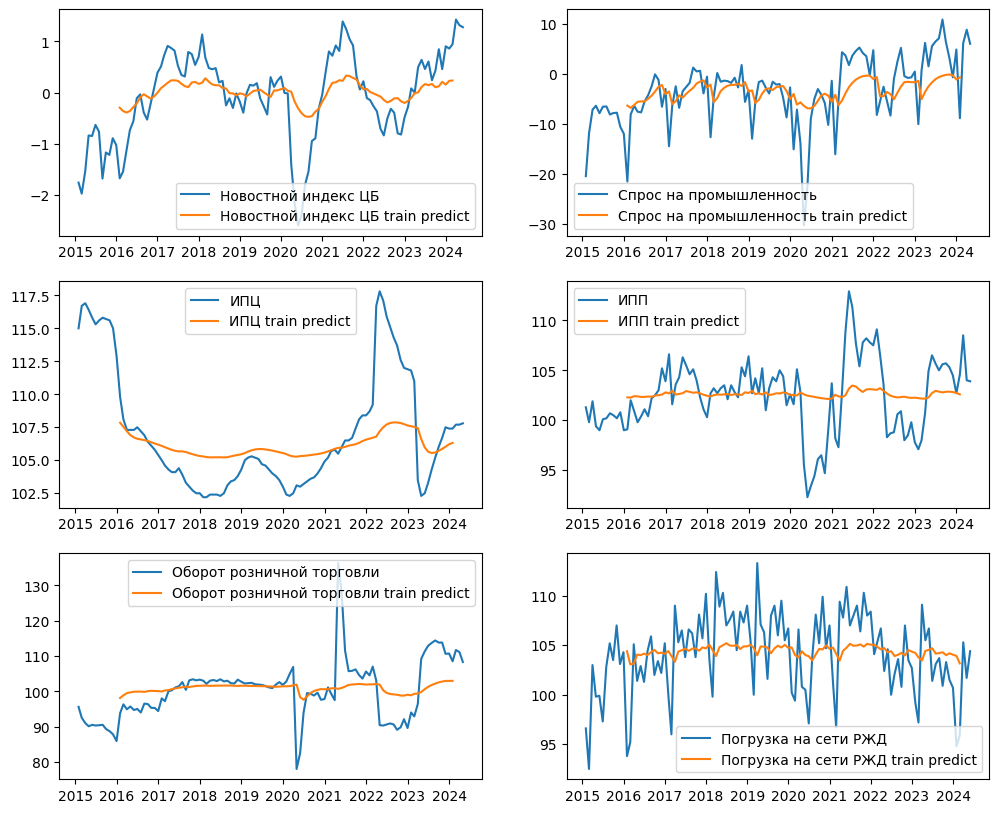

In [67]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

k = 0
for i in range(3):
    for j in range(2):
        label, data = list(indexes.items())[k]
        k += 1

        X, y = reshape_data_for_model(data.z_goal.values, ModelConfig.lookback, ModelConfig.forecast_horizon)
        model = models[label]
        
        pred = scalers[label].inverse_transform(model.predict(X))
        
        # Хорошо бы отделить чертой, где начинается прогноз на тестовой выборке
        # При этом прогноз на тесте нужено действительно сделать итерационным: мы в периоде t, с фактом 12 лагов прогнозируем
        # на t+1; с учетом прогноза на t+1 прогнозируем на t+2 и тд. И эта логика должна быть потом в проде. Ниже примерный код.
        
        axes[i][j].plot(data.date, data.iloc[:, 1], label=label)
        axes[i][j].plot(data.date.iloc[ModelConfig.lookback:-3], pred, label=label + ' прогноз')
        
        axes[i][j].legend()


In [ ]:
# Пример функции для итеративного прогноза
def iterative_prediction(model, X_test, scaler, sequence_length):
    predicted_test = []
    input_seq = X_test[0]
    
    for i in range(len(X_test)):
        prediction = model.predict(input_seq[np.newaxis, :, :])
        predicted_test.append(prediction)
        input_seq = np.vstack([input_seq[1:], prediction])
    
    return np.array(predicted_test).squeeze()